# Description

For this assignment, we explore the task of traffic engineering for a city section of San Francisco. The area we decide to model is the square formed by the intersection of Washington, Montgomery, Sansome, and Clay streets. Below, we have a bird's eye view of the street with traffic layer activated, where darker colors represent higher car density. 

In [1]:
from IPython.display import Image
Image(url= "Screenshot 2022-03-16 000625.png", width=400, height=400)

Montgomery and Sansom are parallel to each other, each dictating vertical flow of traffic in a different direction. Clay and Washington are analogous, but dictating horizontal flow of traffic. Each street has one lane each. We also note that there is more density on Washington and Clay given that they are busier streets (more cars passing).

Regarding traffic lights, we have one at each intersection. Looking at data from SF Traffic Signals Map linked at the assignment and personal observation, we know that they follow an automated traffic light that switchs approximately every 1 minute in synchrony for all 4 of them (which from research online seem to be optimitized for an average bicycle ride to get all greens). 

From the SF Traffic Signals Map, we see that the technology in those specific traffic lights is limited, with the last upgrade in 1999. As such, we propose and explore an updated traffic light system that switches lights not only based on time, but also by incoprorating the density of cars in each road (which is done by sensors in more sophisticated traffic lights). The metric of choice to evaluate whether there is an improvement or not is average traffic flow among all streets.

# Rules

For our initial model, we build on top Nagel & Schreckenberg rules explored in class. Now, we consider that cars have to obey traffic lights and can turn at intersections

- Each car has a current speed, v_t. The next speed is given by v_t+1
- If v_t < v_max then accelerate to v_t + 1 otherwise do not accelerate
- If the number of empty cells between this car and the next car is d < v_t+1, we reduce the speed to d, otherwise speed remains unchanged
- If v_t+1 > 0 reduce the speed v_t+1 - 1 with an assigned probability of slowing down
- Each car moves forward in the direction of the streets until it reaches an intersection
- At an intersection, each car makes a turn as with an assigned probability of turning, otherwise it remains on the same street with probability (1-p_turning)
- If the traffic light is red, the v_t_1 = 0 in the next time step and remains stopped until the light turns green
- Parallel traffic lights change at the same time for every time_step whose modulo with a given timer is 0.
- If a set of parallel lights is red, the other will be green and vice versa
- Average traffic flow is computed as the sum of average speed x card density over all streets divided by number of streets

# Implementation

The code inspired by the following sources:

https://nbviewer.org/urls/course-resources.minerva.kgi.edu/uploaded_files/mke/00212840-6806/traffic-simulation-examples.ipynbhttps://nbviewer.org/urls/course-resources.minerva.kgi.edu/uploaded_files/mke/00212840-6806/traffic-simulation-examples.ipynb

https://embed.cocalc.com/share/public_paths/b2c2c7ecd6cbecfda326b49141102f9144eeb326https://embed.cocalc.com/share/public_paths/b2c2c7ecd6cbecfda326b49141102f9144eeb32

In [2]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import random

In [3]:
class TrafficSimulation:
    def __init__(self, intersection, road_length = 100, car_density = 0.2, 
                 prob_slow = 0.5, max_speed = 5, number_roads = 4):
        
        '''
        Create a new traffic simulation object. Cars are distributed randomly
        along the road and start with random velocities.

        Inputs:

            road_length (int) The number of cells in the road. Default: 100.

            car_density (float) The fraction of cells that have a car on them.
              Default: 0.2.

            prob_slow (float) The probability that a car will randomly slow down
              by 1 during an update step. Default: 0.5.

            max_speed (int) The maximum speed in car cells per update step.
              Default: 5.
              
            number_roads (int) The number of streets we model. Default: 4
            
            intersection (list) Location of each intersection in the grid       
        '''
        
        self.road_length = road_length
        self.car_density = car_density
        self.max_speed = max_speed
        self.prob_slow = prob_slow
        self.number_roads = number_roads
        self.intersection = intersection
        
        
        # Sets parameters for the states of traffic lights
        # We keep track of the current color and whether it's ready
        # to be switched or not
        # We initialize all of them to be green
        self.signal_color = {}
        self.signal_ready = {}
        
        for traffic_light in self.intersection:
            self.signal_ready[traffic_light] = [False]
            self.signal_color[traffic_light] = False

        # Create an empty road: -1 means empty in this simulation
        self.state = np.full(self.road_length, -1, dtype=int)
        
        # tracks the change of state for each road
        self.street_state = []
        self.street_state.append(self.state)
        
        # Choose random locations to place car
        random_indexes = np.random.choice(range(self.road_length),
                                            size = int(round(car_density * self.road_length)),
                                            replace = False)
            
        # Give each car a random initial speed from 0 to max_speed    
        self.state[random_indexes] = np.random.randint(
            0, self.max_speed + 1, size = len(random_indexes))
        
        # Keep track of the time steps and average traffic flow at each step
        self.time_step = 0
        self.average_traffic_flow = []
        
    def light_change(self, signal, position):
        '''
        Change Traffic Lights signal of a given intersection
        '''
        
        self.signal_color[position] = signal
        self.signal_ready[position] = [True]


    def update(self, flow=0):
        '''
        Advance one time step in the simulation.
        '''
        
        # Iterates over every street for every car within the
        # boundary condition
        for lane, state in enumerate(self.street_state):
            start = 0

            for index in range(len(self.intersection) + 1): 
                
                #If still within the boundary, we verify the traffic light
                # if it's green we proceed, if it's red we stop while updating
                # the signal based on the previous switch 
                
                if index < len(self.intersection): 
                    light = self.intersection[index]     
                    if self.signal_color[light]: 
                        self.street_state[lane][light] = 0
                    elif self.street_state[lane][light] == 0 and self.signal_ready[light][lane]:
                        self.street_state[lane][light] = -1
                        self.signal_ready[light][lane] = False                                                
                    border = light
                    
                else: 
                    border = self.road_length
                    
                # Once we verify that the traffic light is green, we apply the
                # normal rules for accelaration, decelartion and randomization
                # for updating the speed of the car
    
                for i in range(start, border):
                    if i in self.intersection:
                        if self.signal_color[i]:
                            continue
                    
                    if self.street_state[lane][i] != -1:
                        distance = 1
                        while self.street_state[lane][(i + distance) % self.road_length] == -1:
                            distance += 1

                        # Acceleration
                        if self.street_state[lane][i] < self.max_speed:
                            self.street_state[lane][i] += 1

                        # Deceleration
                        if self.street_state[lane][i] >= distance:
                            self.street_state[lane][i] = distance - 1
                            
                        # Randomization
                        if ((self.street_state[lane][i] > 0) and
                            (np.random.uniform() < self.prob_slow)):
                            self.street_state[lane][i] -= 1                
                start = light
                
            #Move cars forward using their new speeds
            new_state = np.full(self.road_length, -1, dtype=int)           
            for i in range(self.road_length):
                cell = self.street_state[lane][i]              
                if cell != -1:
                    new_state[(i + cell) % self.road_length] = cell                   
            self.street_state[lane] = new_state

            # Update average traffic flow history
            self.average_traffic_flow.append(
                sum(self.street_state[lane][self.street_state[lane] > 0]) / self.road_length)            
            flow += self.average_traffic_flow[-1]
                                      
        # next time step
        self.time_step += 1

    def display(self):
        '''
        Print out the current state of the simulation.
        '''
        print(''.join('.' if x == -1 else str(x) for x in self.state))

In [4]:
class SignalsControl:
    def __init__(self, streets, prob_turning = 0.2, traffic_timer = 20, run_time = 300):
        """
        Create a new Signals Control simulation object. We use this class to control
        the traffic lights in synchrony.
        
        Inputs:
            
            streets (Instance) Corresponds to each traffic simulation object, which is a given street being modeled
                in the previous class
            
            prob_turning (int) Probability of making a turn at the intersection. Default: 0.2
            
            traffic_timer (int) How long it takes for a traffic light to switch signals. Default: 20
            
            run_time (int) For how many time-steps the simulation will run. Default: 300
        """        
        
        self.streets = streets
        self.prob_turning = prob_turning
        self.run_time = run_time
        self.traffic_timer = traffic_timer
        
        self.prob_continuing = 1 - prob_turning
        self.time_step = 0
        
        
        # Map each intersection by their coordinates in the grid, keeping track of which streets
        # are at which intersection (horizontal and vertical). We assume that they are
        # equidistant from one another. We also initialize the traffic direction to be all the same
        # later updating it, where True means a vertical flow of cars
        self.traffic_dir = [False, False, False, False]
        self.mapping = { 1: {"horizontal": "Washington", "vertical": "Montgomery", "X" : 50, "Y": 25},
                        2: {"horizontal": "Washington", "vertical": "Sansome", "X" : 25, "Y" : 50},
                        3: {"horizontal": "Clay", "vertical": "Montgomery", "X" : 25, "Y" : 50},
                        4: {"horizontal": "Clay", "vertical": "Sansome", "X" : 50, "Y" : 25}}
        
        for i in range(1,5):
            self.update_intersection(i)
        
    def update_intersection(self, intersection):
        """
        Synchronyzes the traffic lights and updates their sign
        """

        # Switches the traffic flow at each intersection based on the
        # traffic light, where we inverse if the signal was green
        if self.traffic_dir[intersection-1] == True:
            self.traffic_dir[intersection-1] = False
        else:
            self.traffic_dir[intersection-1] = True
        
        current_signal_x = self.traffic_dir[intersection - 1]
        x = self.mapping[intersection]["X"]
        
        current_signal_y = not self.traffic_dir[intersection - 1]
        y = self.mapping[intersection]["Y"]
        
        self.streets[self.mapping[intersection]["horizontal"]].light_change(current_signal_x, x)
        self.streets[self.mapping[intersection]["vertical"]].light_change(current_signal_y, y)
            
    def run(self):
        """
        Runs the simulation
        """
        # Run for the inputted amount of time steps
        for i in range(self.run_time):
            # We evaluate for each intersection
            for intersection in self.mapping:
                x = self.mapping[intersection]["horizontal"]
                y = self.mapping[intersection]["vertical"]
                X_coordinate = self.mapping[intersection]["X"]
                Y_coordinate = self.mapping[intersection]["Y"]

                # The traffic lights at intersection always work in pairs,so we set the rules for turning
                # and moving ahead for each pair of intersection. In this case, we look at (Washington and Sansome)
                # and (Clay and Montgomery)                          
                # decides for each car if it will turn or not by drawing from a uniform distribution
                # and comparing with our variable of probability of turning
                
                if X_coordinate == 25:                    
                    street_X_coordinate_m1 = self.streets[x].street_state[-1][X_coordinate - 1]
                    street_X_coordinate_p1 = self.streets[x].street_state[0][X_coordinate + 1]                                   
                    if street_X_coordinate_m1 != -1 and self.streets[y].street_state[-1][Y_coordinate + 1] == -1:
                        if random.uniform (0, 1) <= self.prob_turning:
                            self.streets[y].street_state[-1][Y_coordinate + 1] = street_X_coordinate_m1
                            street_X_coordinate_m1 = -1
                    if street_X_coordinate_p1 == -1 and self.streets[y].street_state[0][Y_coordinate - 1] != -1:
                        if random.uniform (0, 1) <= self.prob_turning:
                            street_X_coordinate_p1 = self.streets[y].street_state[0][Y_coordinate - 1] 
                            self.streets[y].street_state[0][Y_coordinate - 1]  = -1 

                # The same as above, but for (Washington and Montgomery) and (Clay and Sansome)
                elif X_coordinate == 50:                   
                    street_X_coordinate_m1 = self.streets[x].street_state[0][X_coordinate - 1]
                    street_X_coordinate_p1 = self.streets[x].street_state[-1][X_coordinate + 1]                   
                    if street_X_coordinate_m1 != -1 and self.streets[y].street_state[0][Y_coordinate + 1] == -1:
                        if random.uniform (0, 1) <= self.prob_turning:
                            self.streets[y].street_state[0][Y_coordinate + 1] = street_X_coordinate_m1
                            street_X_coordinate_m1 = -1
                    if street_X_coordinate_p1 == -1 and self.streets[y].street_state[-1][Y_coordinate - 1] != -1:
                        if random.uniform (0, 1) <= self.prob_turning:
                            street_X_coordinate_p1 = self.streets[y].street_state[-1][Y_coordinate - 1] 
                            self.streets[y].street_state[-1][Y_coordinate - 1]  = -1  
                
            
            # Update each intersection at every time step that is a
            # multiple of our selected timer
            for street_name in self.streets:
                self.streets[street_name].update()

            if self.time_step % self.traffic_timer == 0:
                for i in range(1,5):
                    self.update_intersection(i)
                    
            self.time_step += 1

    
    def average_traffic_flow (self):
        """
        Calculates the average traffic flow as the
        product of density and speed
        """
        
        total_flow = []
        
        for street in self.streets: 
            total_flow.append(self.streets[street].average_traffic_flow[-1])
            
        return total_flow

In [5]:
# To decide the parameters that govern our probability distributions and other variables,
# we repeatedly tweaked them until it resembled what was shown on Google Maps and by
# observation. We also conduct a sanity check by plotting the average traffic flow over time below

# Parameters common to all roads
road_length = 100
max_speed = 5
prob_slow = 0.5
traffic = [25, 50]
                
# store the average flows for each street            
flows = []

#run the simulation for 100 trials
trials = 200            
for trial in range(trials):
    montgomery =TrafficSimulation(road_length = road_length, car_density = 0.2, max_speed = max_speed,
                                  prob_slow = prob_slow, intersection = traffic)
    
    washington = TrafficSimulation(road_length = road_length, car_density = 0.4, max_speed = max_speed,
                                  prob_slow = prob_slow, intersection = traffic)
    
    clay = TrafficSimulation(road_length = road_length, car_density = 0.6, max_speed = max_speed,
                                  prob_slow = prob_slow, intersection = traffic)
    
    sansome = TrafficSimulation(road_length = road_length, car_density = 0.2, max_speed = max_speed,
                                  prob_slow = prob_slow, intersection = traffic)
    
    model = SignalsControl({"Montgomery": montgomery, "Washington" : washington,
                                   "Clay" : clay, "Sansome": sansome})
    
    # run the model and store average traffic flow          
    model.run()
    flows.append(model.average_traffic_flow())


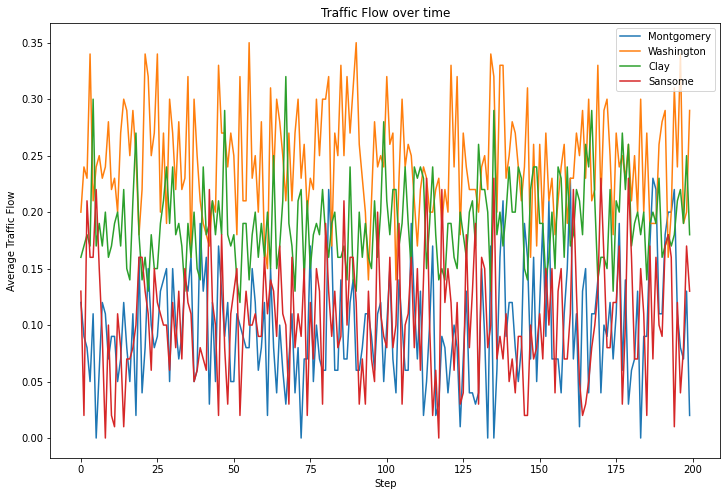

In [6]:
flows = np.array(flows)

plt.figure(figsize=(12, 8))
plt.plot(flows[:,0], label = 'Montgomery')
plt.plot(flows[:,1], label = 'Washington')
plt.plot(flows[:,2], label = 'Clay')
plt.plot(flows[:,3], label = 'Sansome')
plt.xlabel('Step')
plt.ylabel('Average Traffic Flow')
plt.title('Traffic Flow over time')
plt.legend()
plt.show()

From the figure above, we can visualize how the average traffic flow of each street changes over time. Our simulation seems reasonable, with variation over time, but still a clear pattern of less flow on streets with higher density (such as Washington) compared to the rest. As such, our results seem to match what we see in the real world.

Lastly, below we can visualize what is the average traffic flow among all streets

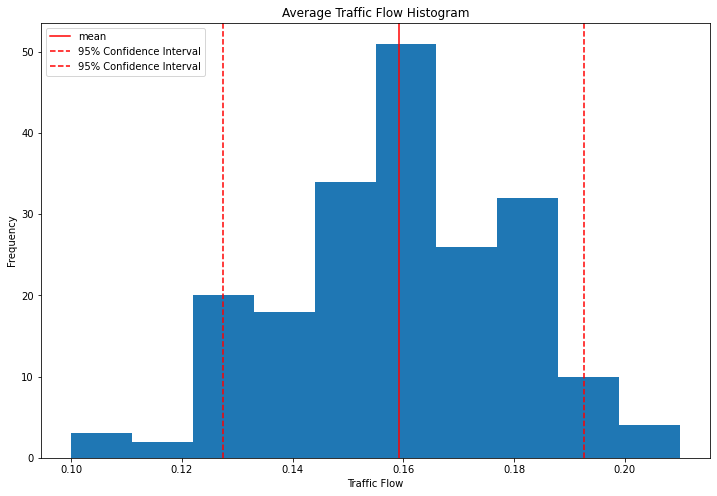

Mean: 0.15931250000000002
Conf Int [0.127375 0.192625]
Std. dev: 0.020423542634665514


In [7]:
results = []

for flow in flows:
    results.append(np.sum(flow)/len(flow))

plt.figure(figsize=(12, 8))
plt.hist(results)
conf_int = np.quantile(results, [0.05, 0.95])
plt.axvline(np.mean(results), c = 'r', label = 'mean')
plt.axvline(conf_int[0], linestyle = '--', c = 'r', label = '95% Confidence Interval')
plt.axvline(conf_int[1], linestyle = '--', c = 'r', label = '95% Confidence Interval')
plt.legend()
plt.title('Average Traffic Flow Histogram')
plt.ylabel('Frequency')
plt.xlabel('Traffic Flow')
plt.show()


print("Mean:", np.mean(results))
print("Conf Int", conf_int)
print("Std. dev:", np.std(results))

Some of the main limitations of our model are that we are considering the density of cars constant throughout the simulation, which is not very realistic considering that there are multiple factors that can influence it (eg. time of the day). However, looking at google maps it seems that Clay and Washington almost always have more cars, so we can be confident in the relation between streets even if our exact measurements are less precise.

Another assumption we take is that the streets have the same length and intersections are equidistantly spaced. This is a simplification that, together with other variables such as incline of each street and pedestrian passage (maybe taking too long to cross the street) goes unaccounted in the model.


# Proposal

Our propsoed traffic light strategy is to shift the traffic light signal based on not only time, but also the density of cars in the street. Ideally, this would make the traffic switch more dynamic, increasing the average flow for all streets.

To implement this, we revisit our SignalsControl class and change the way we update each intersection inside the run method. The waiting time now changes between streets, where we use a factor of our default traffic_timer times the density of the two most dense parallel streets

In [8]:
class SignalsControl:
    def __init__(self, streets, prob_turning = 0.2, traffic_timer = 20, run_time = 300):
        """
        Create a new Signals Control simulation object. We use this class to control
        the traffic lights in synchrony.
        
        Inputs:
            
            streets (Instance) Corresponds to each traffic simulation object, which is a given street being modeled
                in the previous class
            
            prob_turning (int) Probability of making a turn at the intersection. Default: 0.2
            
            traffic_timer (int) How long it takes for a traffic light to switch signals. Default: 20
            
            run_time (int) For how many time-steps the simulation will run. Default: 300
        """        
        
        self.streets = streets
        self.prob_turning = prob_turning
        self.run_time = run_time
        self.traffic_timer = traffic_timer
        
        self.prob_continuing = 1 - prob_turning
        self.time_step = 0
        
        # Sets new attributes for deciding when shift traffict lights based
        # on the two main streets
        self.washington_factor = traffic_timer * streets["Washington"].car_density
        self.clay_factor = traffic_timer * streets["Clay"].car_density
        
        
        # Map each intersection by their coordinates in the grid, keeping track of which streets
        # are at which intersection (horizontal and vertical). We assume that they are
        # equidistant from one another. We also initialize the traffic direction to be all the same
        # later updating it, where True means a vertical flow of cars
        self.traffic_dir = [False, False, False, False]
        self.mapping = { 1: {"horizontal": "Washington", "vertical": "Montgomery", "X" : 50, "Y": 25},
                        2: {"horizontal": "Washington", "vertical": "Sansome", "X" : 25, "Y" : 50},
                        3: {"horizontal": "Clay", "vertical": "Montgomery", "X" : 25, "Y" : 50},
                        4: {"horizontal": "Clay", "vertical": "Sansome", "X" : 50, "Y" : 25}}
        
        for i in range(1,5):
            self.update_intersection(i)
        
    def update_intersection(self, intersection):
        """
        Synchronyzes the traffic lights and updates their sign
        """

        # Switches the traffic flow at each intersection based on the
        # traffic light, where we inverse if the signal was green
        if self.traffic_dir[intersection-1] == True:
            self.traffic_dir[intersection-1] = False
        else:
            self.traffic_dir[intersection-1] = True
        
        current_signal_x = self.traffic_dir[intersection - 1]
        x = self.mapping[intersection]["X"]
        
        current_signal_y = not self.traffic_dir[intersection - 1]
        y = self.mapping[intersection]["Y"]
        
        self.streets[self.mapping[intersection]["horizontal"]].light_change(current_signal_x, x)
        self.streets[self.mapping[intersection]["vertical"]].light_change(current_signal_y, y)
            
    def run(self):
        """
        Runs the simulation
        """
        
        counter = 0
        
        # Run for the inputted amount of time steps
        for i in range(self.run_time):
            # We evaluate for each intersection
            for intersection in self.mapping:
                x = self.mapping[intersection]["horizontal"]
                y = self.mapping[intersection]["vertical"]
                X_coordinate = self.mapping[intersection]["X"]
                Y_coordinate = self.mapping[intersection]["Y"]

                # The traffic lights at intersection always work in pairs,so we set the rules for turning
                # and moving ahead for each pair of intersection. In this case, we look at (Washington and Sansome)
                # and (Clay and Montgomery)                          
                # decides for each car if it will turn or not by drawing from a uniform distribution
                # and comparing with our variable of probability of turning
                
                if X_coordinate == 25:                    
                    street_X_coordinate_m1 = self.streets[x].street_state[-1][X_coordinate - 1]
                    street_X_coordinate_p1 = self.streets[x].street_state[0][X_coordinate + 1]                                   
                    if street_X_coordinate_m1 != -1 and self.streets[y].street_state[-1][Y_coordinate + 1] == -1:
                        if random.uniform (0, 1) <= self.prob_turning:
                            self.streets[y].street_state[-1][Y_coordinate + 1] = street_X_coordinate_m1
                            street_X_coordinate_m1 = -1
                    if street_X_coordinate_p1 == -1 and self.streets[y].street_state[0][Y_coordinate - 1] != -1:
                        if random.uniform (0, 1) <= self.prob_turning:
                            street_X_coordinate_p1 = self.streets[y].street_state[0][Y_coordinate - 1] 
                            self.streets[y].street_state[0][Y_coordinate - 1]  = -1 

                # The same as above, but for (Washington and Montgomery) and (Clay and Sansome)
                elif X_coordinate == 50:                   
                    street_X_coordinate_m1 = self.streets[x].street_state[0][X_coordinate - 1]
                    street_X_coordinate_p1 = self.streets[x].street_state[-1][X_coordinate + 1]                   
                    if street_X_coordinate_m1 != -1 and self.streets[y].street_state[0][Y_coordinate + 1] == -1:
                        if random.uniform (0, 1) <= self.prob_turning:
                            self.streets[y].street_state[0][Y_coordinate + 1] = street_X_coordinate_m1
                            street_X_coordinate_m1 = -1
                    if street_X_coordinate_p1 == -1 and self.streets[y].street_state[-1][Y_coordinate - 1] != -1:
                        if random.uniform (0, 1) <= self.prob_turning:
                            street_X_coordinate_p1 = self.streets[y].street_state[-1][Y_coordinate - 1] 
                            self.streets[y].street_state[-1][Y_coordinate - 1]  = -1  
                
            
            for street_name in self.streets:
                self.streets[street_name].update()
                
            # Update each traffic light based on the factor of the main street
            # that is at that specific intersection. Although they are independent,
            # they are still flipped in pairs since we can't have both streets at green light
            # otherwise creating collisions.
            if self.time_step % self.washington_factor == 0:
                self.update_intersection(1)
                self.update_intersection(2)
                
            if self.traffic_dir[3] == True:
                if counter == self.washington_factor: 
                    self.update_intersection(3)
                    self.update_intersection(4)
                    counter = 0
                else: 
                    counter += 1
                
            elif self.traffic_dir[3] == False:
                if counter == self.clay_factor: 
                    self.update_intersection(3)
                    self.update_intersection(4)
                    counter = 0
                else: 
                    counter += 1
                    
            self.time_step += 1

    
    def average_traffic_flow (self):
        """
        Calculates the average traffic flow as the
        product of density and speed
        """
        
        total_flow = []
        
        for street in self.streets: 
            total_flow.append(self.streets[street].average_traffic_flow[-1])
            
        return total_flow

In [9]:
# To decide the parameters that govern our probability distributions and other variables,
# we repeatedly tweaked them until it resembled what was shown on Google Maps and by
# observation. We also conduct a sanity check by plotting the average traffic flow over time below

# Parameters common to all roads
road_length = 100
max_speed = 5
prob_slow = 0.5
traffic = [25, 50]
                
# store the average flows for each street            
flows = []

#run the simulation for 100 trials
trials = 100     
for trial in range(trials):
    montgomery =TrafficSimulation(road_length = road_length, car_density = 0.2, max_speed = max_speed,
                                  prob_slow = prob_slow, intersection = traffic)
    
    washington = TrafficSimulation(road_length = road_length, car_density = 0.4, max_speed = max_speed,
                                  prob_slow = prob_slow, intersection = traffic)
    
    clay = TrafficSimulation(road_length = road_length, car_density = 0.6, max_speed = max_speed,
                                  prob_slow = prob_slow, intersection = traffic)
    
    sansome = TrafficSimulation(road_length = road_length, car_density = 0.2, max_speed = max_speed,
                                  prob_slow = prob_slow, intersection = traffic)
    
    model = SignalsControl({"Montgomery": montgomery, "Washington" : washington,
                                   "Clay" : clay, "Sansome": sansome})
    
    # run the model and store average traffic flow          
    model.run()
    flows.append(model.average_traffic_flow())


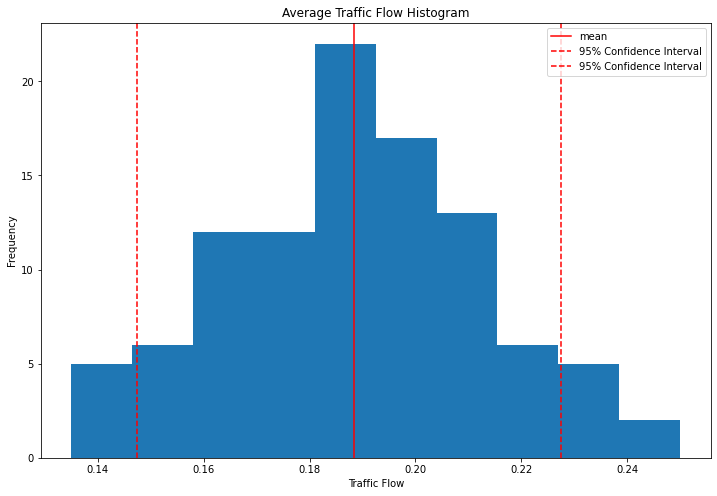

Mean: 0.18844999999999998
Conf Int [0.147375 0.2275  ]
Std. dev: 0.024433020689223015


In [10]:
results = []

for flow in flows:
    results.append(np.sum(flow)/len(flow))

plt.figure(figsize=(12, 8))
plt.hist(results)
conf_int = np.quantile(results, [0.05, 0.95])
plt.axvline(np.mean(results), c = 'r', label = 'mean')
plt.axvline(conf_int[0], linestyle = '--', c = 'r', label = '95% Confidence Interval')
plt.axvline(conf_int[1], linestyle = '--', c = 'r', label = '95% Confidence Interval')
plt.legend()
plt.title('Average Traffic Flow Histogram')
plt.ylabel('Frequency')
plt.xlabel('Traffic Flow')
plt.show()


print("Mean:", np.mean(results))
print("Conf Int", conf_int)
print("Std. dev:", np.std(results))

Our new model has a mean of 0.18 average traffic flow compared to the previous one of 0.15, and as such we would recommend traffic engineers to change their strategy and adopt density sensors in those specific intersections to control how traffic lights are changed. Despite our confidence intervals being slightly large in both visualizations, leading to more uncertainty, we can still clearly see an improvement since the mean of the previous model is close to the lower bound of the confidence interval of our improved strategy.

Further extensions to test our strategy would involve running for more iterations to reduce the width of our confidence interval (which would be computationally expensive), and also varying the density of the streets over multiple iterations to see if our new strategy still outperforms when our two busiest roads become less dense than the rest.